In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader
import torchvision.transforms as T

from data_loader import CustomDataset
from test_data_loader import TestDataset

In [2]:
ROOT = "../hw4_realse_dataset"
BATCH_SIZE = 4
EPOCHS = 50
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
USE_SCHEDULER = False

In [3]:
degraded_dir = f"{ROOT}/train/degraded"
clean_dir = f"{ROOT}/train/clean"
test_dir = f"{ROOT}/test/degraded"

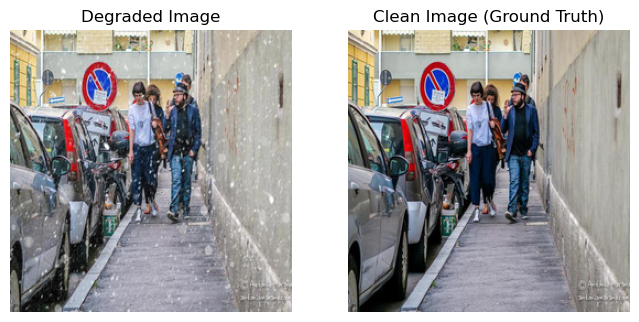

In [4]:
dataset = CustomDataset(degraded_dir, clean_dir)
degraded_img, clean_img = dataset[1600]
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(degraded_img.permute(1, 2, 0))
axs[0].set_title("Degraded Image")
axs[0].axis('off')

axs[1].imshow(clean_img.permute(1, 2, 0))
axs[1].set_title("Clean Image (Ground Truth)")
axs[1].axis('off')

plt.show()

In [5]:
all_files = sorted([
    f for f in os.listdir(degraded_dir)
    if f.lower().endswith(('.png', '.jpg', '.jpeg'))
])
train_files, val_files = train_test_split(
    all_files,
    test_size=0.1,
    random_state=42
)

In [6]:
transform = T.Compose([
    T.Resize((128, 128)),
    T.ToTensor()
])

In [20]:
train_dataset = CustomDataset(
    degraded_dir,
    clean_dir,
    train_files,
    transform=transform
)
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4
)
val_dataset = CustomDataset(
    degraded_dir,
    clean_dir,
    val_files,
    transform=transform
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)
test_dataset = TestDataset(
    test_dir
)
test_loader = DataLoader(
    test_dataset,
    batch_size=1, 
    shuffle=False
)

In [21]:
print(f"Train set: {len(train_dataset)}, Val set: {len(val_dataset)}")

Train set: 2880, Val set: 320


In [22]:
class Base(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Conv2d(in_features, hidden_features, 1)
        self.depthwise = nn.Conv2d(
            hidden_features, hidden_features,
            3, 1, 1, groups=hidden_features
        )
        self.fc2 = nn.Conv2d(hidden_features, out_features, 1)
        # GeLU smoother grad transit than ReLU
        self.activation = nn.GELU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.depthwise(x)
        x = self.activation(x)
        x = self.fc2(x)
        return x

class LayerNormal(nn.Module):
    def __init__(self, channels, epsilon=1e-6):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(channels))
        self.bias = nn.Parameter(torch.zeros(channels))
        self.epsilon = epsilon

    def forward(self, x):
        mu = x.mean(1, keepdim=True)
        var = (x - mu).pow(2).mean(1, keepdim=True)
        x = (x - mu) / (var + self.epsilon).sqrt()
        return (
            self.weight.unsqueeze(0).unsqueeze(2).unsqueeze(3) * x
            + self.bias.unsqueeze(0).unsqueeze(2).unsqueeze(3)
        )
class SwinTransformer(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.norm1 = LayerNormal(channels)
        self.attention = nn.Conv2d(
            channels, channels,
            kernel_size=3, padding=1, groups=channels
        )
        self.norm2 = LayerNormal(channels)
        self.base = Base(channels)

    def forward(self, x):
        x = x + self.attention(self.norm1(x))
        x = x + self.base(self.norm2(x))
        return x

class SwinIR(nn.Module):
    def __init__(
            self, in_channels=3,
            embed_dim=96, num_blocks=12
    ):
        super().__init__()
        self.head = nn.Conv2d(in_channels, embed_dim, kernel_size=3, padding=1)
        self.body = nn.Sequential(
            *[SwinTransformer(embed_dim) for _ in range(num_blocks)]
        )
        self.tail = nn.Conv2d(embed_dim, in_channels, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.head(x)
        x = self.body(x)
        x = self.tail(x)
        return x

In [23]:
class PromptBlock(nn.Module):
    def __init__(self, channels, prompt_dim=32):
        super().__init__()
        self.prompt = nn.Sequential(
            nn.Conv2d(channels, prompt_dim, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(prompt_dim, channels, kernel_size=1)
        )

    def forward(self, x):
        residual = x
        out = self.prompt(x)
        return residual + out

# PromptIR wraps SwinIR and PromptBlock
class PromptIR(nn.Module):
    def __init__(
            self, in_channels=3, prompt_dim=32
    ):
        super().__init__()
        self.backbone = SwinIR(
            in_channels=in_channels
        )
        self.prompt = PromptBlock(in_channels, prompt_dim)

    def forward(self, x, targets=None, criterion=None):
        x = self.backbone(x)
        x = self.prompt(x)
        if self.training and targets is not None and criterion is not None:
            return x, criterion(x, targets)
        return x

In [24]:
def calc_psnr(pred, target, max_pixel=1.0):
    mse = torch.mean((pred - target) ** 2, dim=[1, 2, 3])
    psnr = 20 * torch.log10(max_pixel / torch.sqrt(mse + 1e-8))
    return psnr.mean().item()

In [25]:
model = PromptIR().to(DEVICE)

optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS)
criterion = nn.L1Loss()

In [26]:
model

PromptIR(
  (backbone): SwinIR(
    (head): Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (body): Sequential(
      (0): SwinTransformer(
        (norm1): LayerNormal()
        (attention): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=96)
        (norm2): LayerNormal()
        (base): Base(
          (fc1): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1))
          (depthwise): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=96)
          (fc2): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1))
          (activation): GELU(approximate='none')
        )
      )
      (1): SwinTransformer(
        (norm1): LayerNormal()
        (attention): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=96)
        (norm2): LayerNormal()
        (base): Base(
          (fc1): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1))
          (depthwise): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), paddin

In [ ]:
os.makedirs("checkpoints", exist_ok=True)
epoch_train_losses = []
epoch_val_losses = []
val_psnr = []

for epoch in range(EPOCHS):
    # Training
    model.train()
    train_loss = 0.0
    for degraded, clean in tqdm(
        train_loader,
        desc=f"Training for {epoch+1}",
        leave=False
    ):
        degraded, clean = degraded.to(DEVICE), clean.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(degraded)
        loss = criterion(outputs, clean)
        loss.backward()
        optimizer.step()
        train_loss += float(loss.item()) * degraded.size(0)

    if USE_SCHEDULER:
        scheduler.step()
    avg_train_loss = train_loss / len(train_loader.dataset)
    epoch_train_losses.append(avg_train_loss)

    # Validation
    val_loss = 0.0
    total_psnr = 0.0
    with torch.no_grad():
        for degraded, clean in tqdm(
            val_loader,
            desc=f"Validating for {epoch+1}",
            leave=False
        ):
            degraded, clean = degraded.to(DEVICE), clean.to(DEVICE)
            outputs = model(degraded)
            loss = criterion(outputs, clean)
            val_loss += float(loss.item()) * degraded.size(0)
            psnr = calc_psnr(outputs, clean)
            total_psnr += psnr * degraded.size(0)

    avg_val_loss = val_loss / len(val_loader.dataset)
    epoch_val_losses.append(avg_val_loss)

    avg_psnr = total_psnr / len(val_loader.dataset)
    val_psnr.append(avg_psnr)

    checkpoint_path = f"checkpoints/trained_model_{epoch+1}.pth"
    torch.save(model.state_dict(), checkpoint_path)

    print(
        f"Epoch [{epoch+1}/{EPOCHS}] | "
        f"Train Loss: {avg_train_loss:.4f} | "
        f"Val Loss: {avg_val_loss:.4f} | "
        f"Val PSNR: {avg_psnr:.2f} dB"
    )

In [27]:
# Evaluation on test
def apply_tta(model, image, device):
    model.eval()
    # horizonal flip only
    transforms = [
        lambda x: x,
        lambda x: torch.flip(x, dims=[-1]),
    ]
    inv_transforms = [
        lambda x: x,
        lambda x: torch.flip(x, dims=[-1]),
    ]

    preds = []
    with torch.no_grad():
        for t, inv_t in zip(transforms, inv_transforms):
            aug_img = t(image)
            out = model(aug_img.to(device))
            out = inv_t(out)
            preds.append(out.cpu())
    return torch.stack(preds).mean(0)

In [ ]:
model = PromptIR().to(DEVICE)
model.load_state_dict(
    torch.load("checkpoints/trained_model_50.pth", map_location=DEVICE))
model.eval()

images_dict = {}

with torch.no_grad():
    for img, filename in tqdm(test_loader, desc="Pred generation"):
        img = img.to(DEVICE)
        output = apply_tta(model, img, DEVICE)
        output = output.clamp(0, 1)
        output_np = (output.squeeze().cpu().numpy() * 255).astype(np.uint8)
        images_dict[filename[0]] = output_np

np.savez('pred.npz', **images_dict)
print(f"✅ Saved {len(images_dict)} images to pred.npz")

In [ ]:
# Train & Val loss
plt.figure(figsize=(10, 6))
plt.plot(epoch_train_losses, label="Train Loss", color='red')
plt.plot(epoch_val_losses, label="Validation Loss", color='blue')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()
plt.show()

In [ ]:
# PSNR
plt.figure(figsize=(10, 6))
plt.plot(val_psnr, label="Validation PSNR", color='red')
plt.xlabel("Epoch")
plt.ylabel("PSNR")
plt.title("Validation PSNR per Epoch")
plt.legend()
plt.show()